**Imports + helpers**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

**Générer & visualiser données (1D/2D/3D/4D + 2 distributions)**

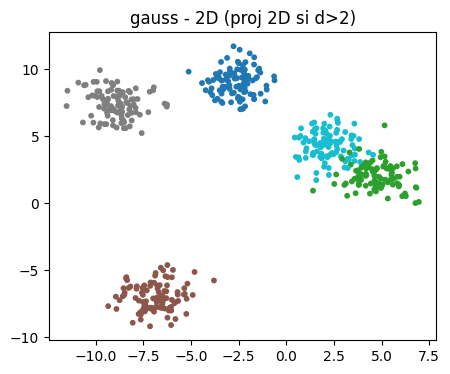

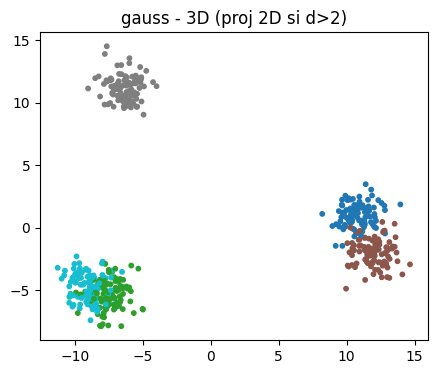

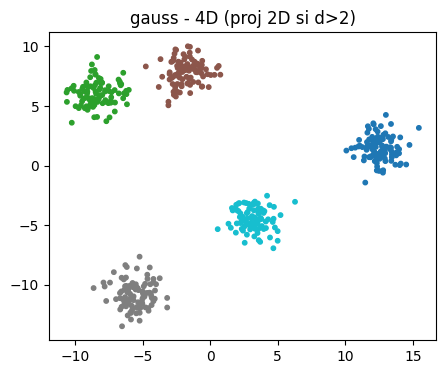

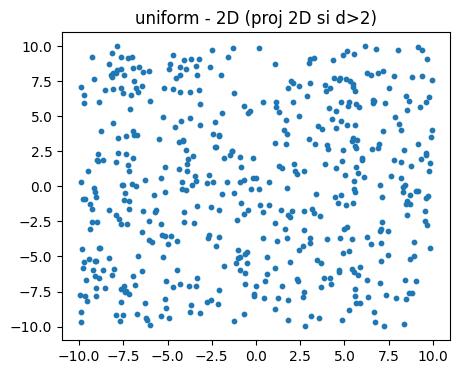

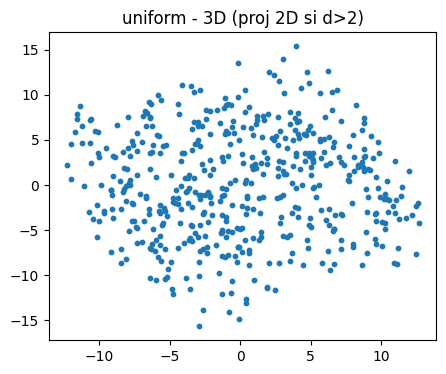

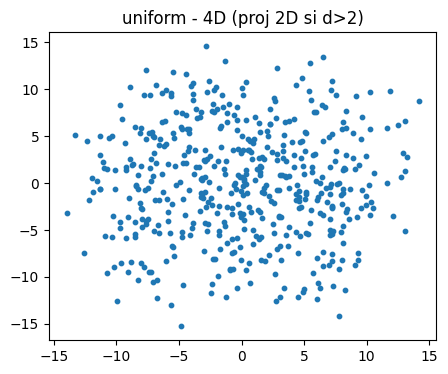

In [2]:
def make_gaussian_data(n=500, d=2, k=5, cluster_std=1.0, seed=42):
    X, y = make_blobs(n_samples=n, centers=k, n_features=d,
                      cluster_std=cluster_std, random_state=seed)
    return X, y

def make_uniform_data(n=500, d=2, low=-10, high=10, seed=42):
    rng = np.random.default_rng(seed)
    X = rng.uniform(low, high, size=(n, d))
    y = None
    return X, y

def visualize_data_2d(X, y=None, title=""):
    d = X.shape[1]
    X2 = X if d == 2 else PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(5,4))
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=10)
    else:
        plt.scatter(X2[:,0], X2[:,1], c=y, s=10, cmap="tab10")
    plt.title(title)
    plt.show()

# Construire la liste des datasets à tester (gauss + uniforme, 1D..4D)
datasets = {}
for dist in ["gauss", "uniform"]:
    for d in [1,2,3,4]:
        if dist == "gauss":
            datasets[(dist, d)] = make_gaussian_data(n=500, d=d, k=5, seed=42)
        else:
            datasets[(dist, d)] = make_uniform_data(n=500, d=d, seed=42)

# Visualiser au moins les cas 2D (et projeter 3D/4D en 2D avec PCA)
for (dist, d), (X, y) in datasets.items():
    if d >= 2:
        visualize_data_2d(X, y, title=f"{dist} - {d}D (proj 2D si d>2)")


**k‑means classique (Lloyd) + SSE + convergence**

In [3]:
def initialize_centers_random(X, k, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=k, replace=False)
    return X[idx].copy()

def compute_labels(X, centers):
    dists = ((X[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
    return np.argmin(dists, axis=1)

def recompute_centers(X, labels, k, seed=0):
    rng = np.random.default_rng(seed)
    centers = np.zeros((k, X.shape[1]))
    for j in range(k):
        pts = X[labels == j]
        centers[j] = pts.mean(axis=0) if len(pts) > 0 else X[rng.integers(len(X))]
    return centers

def sse_error(X, centers, labels):
    return np.sum(((X - centers[labels]) ** 2).sum(axis=1))

def kmeans_lloyd(X, k, num_it=50, seed=0, tol=1e-6, stop_on_convergence=True):
    centers = initialize_centers_random(X, k, seed=seed)
    history = {"centers": [], "sse": []}

    for it in range(num_it):
        labels = compute_labels(X, centers)
        history["centers"].append(centers.copy())
        history["sse"].append(float(sse_error(X, centers, labels)))

        new_centers = recompute_centers(X, labels, k, seed=seed+it)
        if stop_on_convergence and np.allclose(new_centers, centers, atol=tol):
            centers = new_centers
            break
        centers = new_centers

    labels = compute_labels(X, centers)
    return centers, labels, history

def plot_sse(history, title="SSE vs iterations"):
    plt.figure(figsize=(5,4))
    plt.plot(history["sse"], marker="o")
    plt.xlabel("iteration")
    plt.ylabel("SSE")
    plt.title(title)
    plt.show()


**Visualiser clusters + centres**

In [4]:
def visualize_clusters(X, labels, centers=None, title=""):
    d = X.shape[1]
    X2 = X if d == 2 else PCA(n_components=2).fit_transform(X)

    plt.figure(figsize=(5,4))
    if labels is None:
        plt.scatter(X2[:,0], X2[:,1], s=10)
    else:
        plt.scatter(X2[:,0], X2[:,1], c=labels, s=10, cmap="tab10")

    if centers is not None:
        C2 = centers if d == 2 else PCA(n_components=2).fit_transform(centers)
        plt.scatter(C2[:,0], C2[:,1], c="black", s=120, marker="X")

    plt.title(title)
    plt.show()


**Exécuter point 2 sur un dataset**

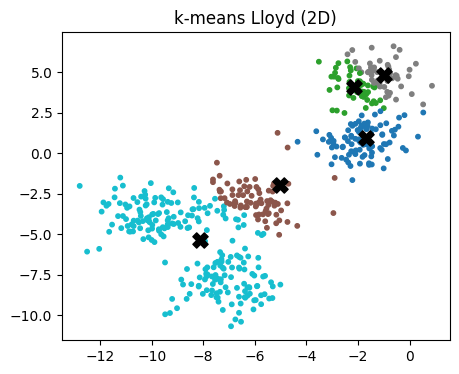

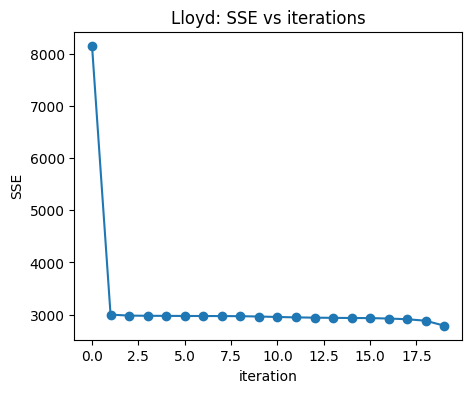

Iterations: 20 Final SSE: 2789.4005977197903


In [5]:
X, y_true = make_gaussian_data(n=500, d=2, k=5, seed=1)
centers, labels, hist = kmeans_lloyd(X, k=5, num_it=20, seed=0, stop_on_convergence=True)

visualize_clusters(X, labels, centers, title="k-means Lloyd (2D)")
plot_sse(hist, title="Lloyd: SSE vs iterations")
print("Iterations:", len(hist["sse"]), "Final SSE:", hist["sse"][-1])


**k-means++ et comparaison**

In [6]:
def initialize_centers_kmeanspp(X, k, seed=0):
    rng = np.random.default_rng(seed)
    n = len(X)

    centers = [X[rng.integers(n)]]
    for _ in range(1, k):
        C = np.array(centers)
        d2 = ((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2).min(axis=1)
        probs = d2 / d2.sum()
        centers.append(X[rng.choice(n, p=probs)])
    return np.array(centers)

def kmeans_generic(X, k, init="random", num_it=50, seed=0, tol=1e-6, stop_on_convergence=True):
    if init == "random":
        centers = initialize_centers_random(X, k, seed=seed)
    elif init == "kmeans++":
        centers = initialize_centers_kmeanspp(X, k, seed=seed)
    else:
        raise ValueError("init must be 'random' or 'kmeans++'")

    history = {"centers": [], "sse": []}
    for it in range(num_it):
        labels = compute_labels(X, centers)
        history["centers"].append(centers.copy())
        history["sse"].append(float(sse_error(X, centers, labels)))

        new_centers = recompute_centers(X, labels, k, seed=seed+it)
        if stop_on_convergence and np.allclose(new_centers, centers, atol=tol):
            centers = new_centers
            break
        centers = new_centers

    labels = compute_labels(X, centers)
    return centers, labels, history

# Comparaison sur plusieurs runs
X, _ = make_gaussian_data(n=500, d=2, k=5, seed=2)
seeds = range(10)

results = []
for s in seeds:
    _, _, h_r = kmeans_generic(X, 5, init="random", seed=s)
    _, _, h_p = kmeans_generic(X, 5, init="kmeans++", seed=s)
    results.append((s, len(h_r["sse"]), h_r["sse"][-1], len(h_p["sse"]), h_p["sse"][-1]))

results[:5], ("avg iters random", np.mean([r[1] for r in results]),
              "avg iters k++", np.mean([r[3] for r in results]))


([(0, 14, 940.0640910457589, 3, 1190.0940161664164),
  (1, 6, 1172.876657434137, 9, 940.061986593627),
  (2, 9, 1176.461757777257, 5, 940.0947875598289),
  (3, 7, 1189.9837845025309, 7, 1185.7319158759014),
  (4, 11, 1183.2936409178992, 5, 940.061986593627)],
 ('avg iters random', np.float64(10.6), 'avg iters k++', np.float64(8.2)))

**Mini‑batch k‑means plus test 10 000+**

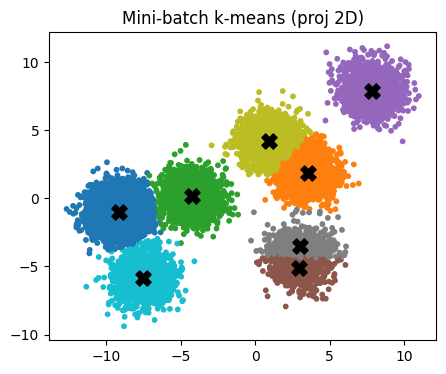

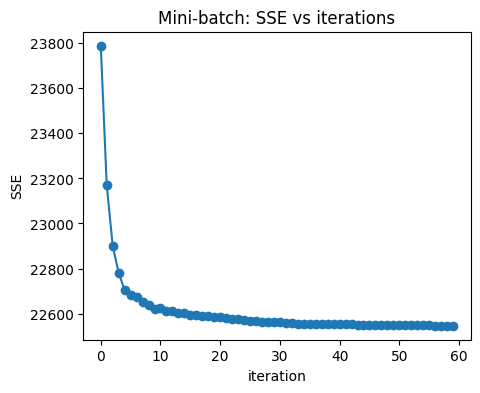

Final SSE: 22546.21683068889


In [7]:
def minibatch_kmeans(X, k, batch_size=256, num_it=200, init="kmeans++", seed=0):
    rng = np.random.default_rng(seed)
    n, d = X.shape

    centers = initialize_centers_kmeanspp(X, k, seed=seed) if init == "kmeans++" else initialize_centers_random(X, k, seed=seed)
    counts = np.zeros(k, dtype=int)
    history = {"centers": [], "sse": []}

    for it in range(num_it):
        batch_idx = rng.choice(n, size=min(batch_size, n), replace=False)
        B = X[batch_idx]
        labels_b = compute_labels(B, centers)

        for j, x in zip(labels_b, B):
            counts[j] += 1
            eta = 1.0 / counts[j]
            centers[j] = (1 - eta) * centers[j] + eta * x

        labels_all = compute_labels(X, centers)
        history["centers"].append(centers.copy())
        history["sse"].append(float(sse_error(X, centers, labels_all)))

    labels_final = compute_labels(X, centers)
    return centers, labels_final, history

X_big, _ = make_gaussian_data(n=12000, d=2, k=8, seed=3)
cent_mb, lab_mb, hist_mb = minibatch_kmeans(X_big, k=8, batch_size=512, num_it=60, seed=0)

visualize_clusters(X_big, lab_mb, cent_mb, title="Mini-batch k-means (proj 2D)")
plot_sse(hist_mb, title="Mini-batch: SSE vs iterations")
print("Final SSE:", hist_mb["sse"][-1])


**Tester plusieurs k (coude + silhouette)**

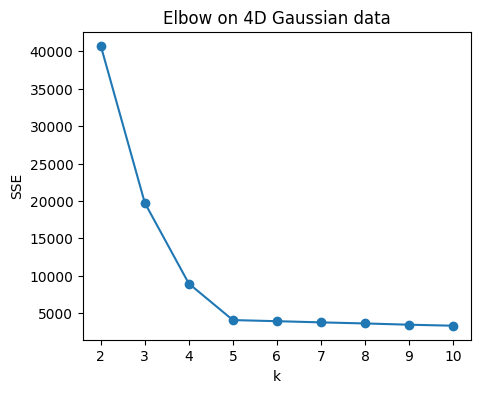

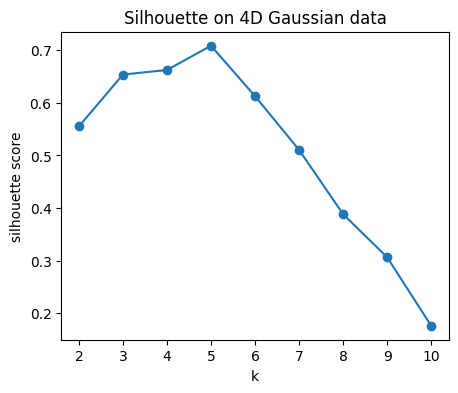

(5, 4079.3549114004672, np.float64(0.7085843170995202))

In [8]:
def evaluate_k(X, k_values, algo="lloyd", seed=0):
    rows = []
    for k in k_values:
        if algo == "lloyd":
            centers, labels, hist = kmeans_generic(X, k, init="kmeans++", seed=seed)
        elif algo == "minibatch":
            centers, labels, hist = minibatch_kmeans(X, k, seed=seed, num_it=100)
        else:
            raise ValueError("algo must be 'lloyd' or 'minibatch'")

        final_sse = hist["sse"][-1]
        sil = silhouette_score(X, labels) if k > 1 else np.nan
        rows.append((k, final_sse, sil))
    return rows

def plot_elbow(rows, title="Elbow (SSE)"):
    ks = [r[0] for r in rows]
    sses = [r[1] for r in rows]
    plt.figure(figsize=(5,4))
    plt.plot(ks, sses, marker="o")
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.title(title)
    plt.show()

def plot_sil(rows, title="Silhouette"):
    ks = [r[0] for r in rows]
    sils = [r[2] for r in rows]
    plt.figure(figsize=(5,4))
    plt.plot(ks, sils, marker="o")
    plt.xlabel("k")
    plt.ylabel("silhouette score")
    plt.title(title)
    plt.show()

X, _ = make_gaussian_data(n=1000, d=4, k=5, seed=5)  # exemple 4D
rows = evaluate_k(X, k_values=range(2, 11), algo="lloyd", seed=0)

plot_elbow(rows, title="Elbow on 4D Gaussian data")
plot_sil(rows, title="Silhouette on 4D Gaussian data")

best_by_sil = max(rows, key=lambda t: t[2])
best_by_sil
